# **Neuropolis-X1**
### **Building an artificial intelligence system for human brain activity prediction (EEG, fMRI) with machine learning, deep learning, and large language models**

#### Maël Donoso, Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/)
*18th March 2025*

This first extension (X1) of Neuropolis includes twelve Notebooks:

*01: fMRI Preprocessing*

*02: EEG Preprocessing*

*03: Classification Models*

***04: Regression Models***

*05: Neural Networks*

*06: Convolutional Neural Networks*

*07: Recurrent Neural Networks*

*08: Transformers*

*09: Large Language Models*

*10: Large Language Model Chain-of-Thought*

*11: Large Language Model Fine-Tuning*

*12: Large Multimodal Model*

### Notebook 04

# **Regression Models**

## **1. Linear Regression, Ridge, Lasso**

We run a **linear regression model** on all subjects, except sub-xp102 who has a missing condition, and use the eegfmriNF condition as the train set, and the eegNF and fmriNF conditions as the test set. We also run a linear regression with **Ridge** and **Lasso** regularizations, and use the R^2 as our metrics. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [2]:
# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis-x1_preprocessed_data/'

# Define the results path. 
results_path = '../neuropolis-x1_results/'

In [3]:
# Load the features, the targets, and the baseline. 
with open(preprocessed_data_path + 'dict_features_bandpowers_normalized.p', 'rb') as file:
    dict_features_bandpowers = pickle.load(file)
with open(preprocessed_data_path + 'dict_targets.p', 'rb') as file:
    dict_targets = pickle.load(file)
with open(preprocessed_data_path + 'dict_baseline.p', 'rb') as file:
    dict_baseline_original = pickle.load(file)

In [4]:
# Define the list of subjects and define an example subject. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
subject = subjects[0]

# Retrieve the list of all targets. 
targets = list(dict_targets[subject]['eegfmriNF'].keys())

# Select a sequence length. 
selected_sequence_length = 5

# Retrieve the total number of scans. 
nb_scans_total = dict_targets[subject]['eegfmriNF']['Frontal Pole'].shape[0]

In [5]:
# Define the dictionaries and the summary DataFrame for storing the features, targets, and baseline. 
dict_features_basis = dict()
dict_features_sequence = dict()
dict_targets_basis = dict()
dict_targets_sequence = dict()
dict_baseline_basis = dict()
dict_baseline_sequence = dict()
df_summary_global = pd.DataFrame()

# Iterate through all subjects. 
for subject in subjects:
        
    # Define the subject dictionaries. 
    dict_features_basis[subject] = dict()
    dict_features_sequence[subject] = dict()
    dict_targets_basis[subject] = dict()
    dict_targets_sequence[subject] = dict()
    dict_baseline_basis[subject] = dict()
    dict_baseline_sequence[subject] = dict()

    # Iterate through all conditions. 
    for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

        # Skip the current iteration for sub-xp102 and eegNF, since that run is missing. 
        if subject == 'sub-xp102' and condition == 'eegNF':
            continue
            
        # Define the general features array by stacking all the EEG channels. 
        X_basis = np.vstack(dict_features_bandpowers[subject][condition]).transpose()

        # Define the general targets array. 
        Y_basis = np.zeros((nb_scans_total, len(targets)))
        for target_index in range(len(targets)):
            Y_basis[:, target_index] = dict_targets[subject][condition][targets[target_index]]

        # Define the general baseline array. 
        Baseline_basis = np.zeros((nb_scans_total, len(targets)))
        for target_index in range(len(targets)):
            Baseline_basis[:, target_index] = dict_baseline_original[subject][condition][targets[target_index]]

        # Define the particular features array. 
        X_sequence = np.zeros((nb_scans_total - selected_sequence_length, X_basis.shape[1] * (selected_sequence_length + 1)))
        for scan in range(nb_scans_total - selected_sequence_length):
            X_sequence[scan, :] = X_basis[scan:(scan + selected_sequence_length + 1), :].ravel()

        # Define the particular targets array. 
        Y_sequence = Y_basis[selected_sequence_length:, :]

        # Define the particular baseline array. 
        Baseline_sequence = Baseline_basis[selected_sequence_length:, :]

        # Store the features, targets and baseline in the dictionaries. 
        dict_features_basis[subject][condition] = X_basis
        dict_features_sequence[subject][condition] = X_sequence
        dict_targets_basis[subject][condition] = Y_basis
        dict_targets_sequence[subject][condition] = Y_sequence
        dict_baseline_basis[subject][condition] = Baseline_basis
        dict_baseline_sequence[subject][condition] = Baseline_sequence

        # Store the shapes of the arrays in the DataFrame. 
        df_summary_global.loc[subject + '/' + condition, 'subject'] = subject
        df_summary_global.loc[subject + '/' + condition, 'condition'] = condition
        df_summary_global.loc[subject + '/' + condition, 'X_basis.shape'] = str(X_basis.shape)
        df_summary_global.loc[subject + '/' + condition, 'X_sequence.shape'] = str(X_sequence.shape)
        df_summary_global.loc[subject + '/' + condition, 'Y_basis.shape'] = str(Y_basis.shape)
        df_summary_global.loc[subject + '/' + condition, 'Y_sequence.shape'] = str(Y_sequence.shape)
        df_summary_global.loc[subject + '/' + condition, 'Baseline_basis.shape'] = str(Baseline_basis.shape)
        df_summary_global.loc[subject + '/' + condition, 'Baseline_sequence.shape'] = str(Baseline_sequence.shape)

# Change the indexes of the DataFrame. 
df_summary_global = df_summary_global.set_index(['subject', 'condition'])

In [6]:
# Display the summary DataFrame. 
df_summary_global

X_basis.shape X_sequence.shape Y_basis.shape  \
subject   condition                                                
sub-xp101 eegNF        (200, 378)      (195, 2268)     (200, 49)   
          fmriNF       (200, 378)      (195, 2268)     (200, 49)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 49)   
sub-xp102 fmriNF       (200, 378)      (195, 2268)     (200, 49)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 49)   
sub-xp103 eegNF        (200, 378)      (195, 2268)     (200, 49)   
          fmriNF       (200, 378)      (195, 2268)     (200, 49)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 49)   
sub-xp104 eegNF        (200, 378)      (195, 2268)     (200, 49)   
          fmriNF       (200, 378)      (195, 2268)     (200, 49)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 49)   
sub-xp105 eegNF        (200, 378)      (195, 2268)     (200, 49)   
          fmriNF       (200, 378)      (195, 2268)     (200, 49)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 49)   
sub-xp106 eegNF        (200, 378)      (195, 2268)     (200, 49)   
          fmriNF       (200, 378)      (195, 2268)     (200, 49)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 49)   
sub-xp107 eegNF        (200, 378)      (195, 2268)     (200, 49)   
          fmriNF       (200, 378)      (195, 2268)     (200, 49)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 49)   
sub-xp108 eegNF        (200, 378)      (195, 2268)     (200, 49)   
          fmriNF       (200, 378)      (195, 2268)     (200, 49)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 49)   
sub-xp109 eegNF        (200, 378)      (195, 2268)     (200, 49)   
          fmriNF       (200, 378)      (195, 2268)     (200, 49)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 49)   
sub-xp110 eegNF        (200, 378)      (195, 2268)     (200, 49)   
          fmriNF       (200, 378)      (195, 2268)     (200, 49)   
          eegfmriNF    (200, 378)      (195, 2268)     (200, 49)   

                    Y_sequence.shape Baseline_basis.shape  \
subject   condition                                         
sub-xp101 eegNF            (195, 49)            (200, 49)   
          fmriNF           (195, 49)            (200, 49)   
          eegfmriNF        (195, 49)            (200, 49)   
sub-xp102 fmriNF           (195, 49)            (200, 49)   
          eegfmriNF        (195, 49)            (200, 49)   
sub-xp103 eegNF            (195, 49)            (200, 49)   
          fmriNF           (195, 49)            (200, 49)   
          eegfmriNF        (195, 49)            (200, 49)   
sub-xp104 eegNF            (195, 49)            (200, 49)   
          fmriNF           (195, 49)            (200, 49)   
          eegfmriNF        (195, 49)            (200, 49)   
sub-xp105 eegNF            (195, 49)            (200, 49)   
          fmriNF           (195, 49)            (200, 49)   
          eegfmriNF        (195, 49)            (200, 49)   
sub-xp106 eegNF            (195, 49)            (200, 49)   
          fmriNF           (195, 49)            (200, 49)   
          eegfmriNF        (195, 49)            (200, 49)   
sub-xp107 eegNF            (195, 49)            (200, 49)   
          fmriNF           (195, 49)            (200, 49)   
          eegfmriNF        (195, 49)            (200, 49)   
sub-xp108 eegNF            (195, 49)            (200, 49)   
          fmriNF           (195, 49)            (200, 49)   
          eegfmriNF        (195, 49)            (200, 49)   
sub-xp109 eegNF            (195, 49)            (200, 49)   
          fmriNF           (195, 49)            (200, 49)   
          eegfmriNF        (195, 49)            (200, 49)   
sub-xp110 eegNF            (195, 49)            (200, 49)   
          fmriNF           (195, 49)            (200, 49)   
          eegfmriNF        (195, 49)            (200, 49)   

                   

In [7]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [8]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [9]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [10]:
# Define a function to run a regression model. 
def run_regression_model(RegressionModel, dict_features_sequence, dict_targets_sequence, dict_baseline_sequence, parameter_name):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # TRAINING LOOP. Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Scikit-Learn estimator. 
        PredictorBrain = clone(RegressionModel)

        # Retrieve the features and targets of the train set. 
        X_tr = dict_features_sequence[subject]['eegfmriNF']
        Y_tr = dict_targets_sequence[subject]['eegfmriNF']

        # Train the model. 
        PredictorBrain.fit(X_tr, Y_tr)

        # Store the trained model in the dictionary. 
        dict_models[subject] = PredictorBrain

    # PREDICTION LOOP. Iterate through all subjects. 
    for subject in subjects:

        # Define the subject dictionary. 
        dict_predictions[subject] = dict()

        # Iterate through all conditions. 
        for condition in ['eegNF', 'fmriNF']:

            # Skip the current iteration for sub-xp102 and eegNF, since that run is missing. 
            if subject == 'sub-xp102' and condition == 'eegNF':
                continue

            # Retrieve the features and targets of the test set, the baseline, and the trained model. 
            X_te = dict_features_sequence[subject][condition]
            Y_te = dict_targets_sequence[subject][condition]
            Baseline = dict_baseline_sequence[subject]['eegfmriNF']
            PredictorBrain = dict_models[subject]

            # Predict the target values. 
            Y_pred = PredictorBrain.predict(X_te)

            # Evaluate the performance metrics. 
            mse_baseline = MSE(Y_te, Baseline)
            mae_baseline = MAE(Y_te, Baseline)
            rss_baseline = RSS(Y_te, Baseline)
            mse_model = MSE(Y_te, Y_pred)
            mae_model = MAE(Y_te, Y_pred)
            rss_model = RSS(Y_te, Y_pred)
            r2_model = 1 - (rss_model / rss_baseline)

            # Store the performance metrics and the shapes of the arrays in the DataFrame. 
            df_summary.loc[subject + '/' + condition, 'subject'] = subject
            df_summary.loc[subject + '/' + condition, 'condition'] = condition
            df_summary.loc[subject + '/' + condition, 'mse_baseline'] = mse_baseline
            df_summary.loc[subject + '/' + condition, 'mae_baseline'] = mae_baseline
            df_summary.loc[subject + '/' + condition, 'rss_baseline'] = rss_baseline
            df_summary.loc[subject + '/' + condition, 'mse_model'] = mse_model
            df_summary.loc[subject + '/' + condition, 'mae_model'] = mae_model
            df_summary.loc[subject + '/' + condition, 'rss_model'] = rss_model
            df_summary.loc[subject + '/' + condition, 'r2_model'] = r2_model
            df_summary.loc[subject + '/' + condition, 'X_tr.shape'] = str(X_tr.shape)
            df_summary.loc[subject + '/' + condition, 'X_te.shape'] = str(X_te.shape)
            df_summary.loc[subject + '/' + condition, 'Y_tr.shape'] = str(Y_tr.shape)
            df_summary.loc[subject + '/' + condition, 'Y_te.shape'] = str(Y_te.shape)
            if parameter_name != '':
                df_summary.loc[subject + '/' + condition, parameter_name] = PredictorBrain.best_params_[parameter_name]

            # Store the predictions in the dictionary. 
            dict_predictions[subject][condition] = Y_pred

    # Change the indexes of the DataFrame. 
    df_summary = df_summary.set_index(['subject', 'condition'])
    
    return dict_models, dict_predictions, df_summary

In [11]:
# Run the regression model. 
dict_models_lr, dict_predictions_lr, df_summary_lr = run_regression_model(LinearRegression(), 
                                                                          dict_features_sequence, 
                                                                          dict_targets_sequence, 
                                                                          dict_baseline_sequence, 
                                                                          parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [12]:
# Display the results. 
print('Linear Regression')
df_summary_lr

Linear Regression


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.748643      0.673287   7153.281594   1.674562   
          fmriNF         0.814647      0.717371   7783.953118   1.474254   
sub-xp102 fmriNF         0.923214      0.793705   8821.309205   1.215696   
sub-xp103 eegNF          0.891261      0.764916   8515.998123   1.255588   
          fmriNF         0.941295      0.791543   8994.078014   1.077283   
sub-xp104 eegNF          0.754419      0.664922   7208.473926   1.024985   
          fmriNF         0.869679      0.754163   8309.778638   1.239601   
sub-xp105 eegNF          0.975536      0.788727   9321.244612   1.410237   
          fmriNF         0.971046      0.802868   9278.343093   1.513257   
sub-xp106 eegNF          0.960283      0.794260   9175.499629   1.236618   
          fmriNF         0.910464      0.783408   8699.481856   1.532414   
sub-xp107 eegNF          0.948845      0.783694   9066.210165   1.458137   
          fmriNF         0.983027      0.808135   9392.826436   1.399265   
sub-xp108 eegNF          0.971835      0.808577   9285.881629   1.071261   
          fmriNF         0.986404      0.817478   9425.086354   0.986173   
sub-xp109 eegNF          0.967838      0.813239   9247.691064   1.670251   
          fmriNF         0.960929      0.801149   9181.676614   1.314148   
sub-xp110 eegNF          0.958675      0.788212   9160.139889   1.228646   
          fmriNF         0.970518      0.804844   9273.296161   1.164675   

                     mae_model     rss_model  r2_model   X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF       1.031963  16000.440178 -1.236797  (195, 2268)   
          fmriNF      0.976299  14086.492682 -0.809684  (195, 2268)   
sub-xp102 fmriNF      0.875913  11615.979072 -0.316809  (195, 2268)   
sub-xp103 eegNF       0.908617  11997.143181 -0.408777  (195, 2268)   
          fmriNF      0.816973  10293.443382 -0.144469  (195, 2268)   
sub-xp104 eegNF       0.780410   9793.735343 -0.358642  (195, 2268)   
          fmriNF      0.877085  11844.388161 -0.425355  (195, 2268)   
sub-xp105 eegNF       0.947792  13474.815470 -0.445603  (195, 2268)   
          fmriNF      0.987220  14459.172683 -0.558379  (195, 2268)   
sub-xp106 eegNF       0.876861  11815.886681 -0.287765  (195, 2268)   
          fmriNF      0.995406  14642.218705 -0.683114  (195, 2268)   
sub-xp107 eegNF       0.966666  13932.499798 -0.536750  (195, 2268)   
          fmriNF      0.950507  13369.976752 -0.423424  (195, 2268)   
sub-xp108 eegNF       0.809131  10235.900558 -0.102308  (195, 2268)   
          fmriNF      0.792585   9422.884397  0.000234  (195, 2268)   
sub-xp109 eegNF       1.047971  15959.243908 -0.725754  (195, 2268)   
          fmriNF      0.904522  12556.681412 -0.367580  (195, 2268)   
sub-xp110 eegNF       0.882851  11739.711673 -0.281608  (195, 2268)   
          fmriNF      0.855711  11128.472025 -0.200056  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  
subject   condition                                     
sub-xp101 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp102 fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp103 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp104 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp105 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp106 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp107 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp108 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF    

In [13]:
# Run the regression model. 
dict_models_ridge, dict_predictions_ridge, df_summary_ridge = run_regression_model(Ridge(), 
                                                                                   dict_features_sequence, 
                                                                                   dict_targets_sequence, 
                                                                                   dict_baseline_sequence, 
                                                                                   parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [14]:
# Display the results. 
print('Ridge Regression')
df_summary_ridge

Ridge Regression


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.748643      0.673287   7153.281594   1.670842   
          fmriNF         0.814647      0.717371   7783.953118   1.470439   
sub-xp102 fmriNF         0.923214      0.793705   8821.309205   1.214554   
sub-xp103 eegNF          0.891261      0.764916   8515.998123   1.254521   
          fmriNF         0.941295      0.791543   8994.078014   1.076098   
sub-xp104 eegNF          0.754419      0.664922   7208.473926   1.023916   
          fmriNF         0.869679      0.754163   8309.778638   1.238094   
sub-xp105 eegNF          0.975536      0.788727   9321.244612   1.407448   
          fmriNF         0.971046      0.802868   9278.343093   1.509360   
sub-xp106 eegNF          0.960283      0.794260   9175.499629   1.234303   
          fmriNF         0.910464      0.783408   8699.481856   1.529526   
sub-xp107 eegNF          0.948845      0.783694   9066.210165   1.456236   
          fmriNF         0.983027      0.808135   9392.826436   1.397225   
sub-xp108 eegNF          0.971835      0.808577   9285.881629   1.070114   
          fmriNF         0.986404      0.817478   9425.086354   0.985204   
sub-xp109 eegNF          0.967838      0.813239   9247.691064   1.667695   
          fmriNF         0.960929      0.801149   9181.676614   1.311986   
sub-xp110 eegNF          0.958675      0.788212   9160.139889   1.227716   
          fmriNF         0.970518      0.804844   9273.296161   1.163265   

                     mae_model     rss_model  r2_model   X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF       1.030805  15964.891786 -1.231828  (195, 2268)   
          fmriNF      0.975031  14050.042320 -0.805001  (195, 2268)   
sub-xp102 fmriNF      0.875507  11605.060304 -0.315571  (195, 2268)   
sub-xp103 eegNF       0.908247  11986.951725 -0.407580  (195, 2268)   
          fmriNF      0.816538  10282.117420 -0.143210  (195, 2268)   
sub-xp104 eegNF       0.779972   9783.519714 -0.357225  (195, 2268)   
          fmriNF      0.876589  11829.988890 -0.423623  (195, 2268)   
sub-xp105 eegNF       0.946873  13448.166544 -0.442744  (195, 2268)   
          fmriNF      0.985988  14421.937717 -0.554366  (195, 2268)   
sub-xp106 eegNF       0.876102  11793.767789 -0.285354  (195, 2268)   
          fmriNF      0.994487  14614.617539 -0.679941  (195, 2268)   
sub-xp107 eegNF       0.966016  13914.339720 -0.534747  (195, 2268)   
          fmriNF      0.949850  13350.488134 -0.421349  (195, 2268)   
sub-xp108 eegNF       0.808702  10224.941655 -0.101128  (195, 2268)   
          fmriNF      0.792243   9413.624989  0.001216  (195, 2268)   
sub-xp109 eegNF       1.047267  15934.826561 -0.723114  (195, 2268)   
          fmriNF      0.903813  12536.024263 -0.365331  (195, 2268)   
sub-xp110 eegNF       0.882546  11730.830052 -0.280639  (195, 2268)   
          fmriNF      0.855198  11115.000645 -0.198603  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  
subject   condition                                     
sub-xp101 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp102 fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp103 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp104 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp105 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp106 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp107 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp108 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF    

In [15]:
# Run the regression model. 
dict_models_lasso, dict_predictions_lasso, df_summary_lasso = run_regression_model(Lasso(), 
                                                                                   dict_features_sequence, 
                                                                                   dict_targets_sequence, 
                                                                                   dict_baseline_sequence, 
                                                                                   parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [16]:
# Display the results. 
print('Lasso Regression')
df_summary_lasso

Lasso Regression


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.748643      0.673287   7153.281594   0.747283   
          fmriNF         0.814647      0.717371   7783.953118   0.812692   
sub-xp102 fmriNF         0.923214      0.793705   8821.309205   0.922221   
sub-xp103 eegNF          0.891261      0.764916   8515.998123   0.890367   
          fmriNF         0.941295      0.791543   8994.078014   0.940879   
sub-xp104 eegNF          0.754419      0.664922   7208.473926   0.750850   
          fmriNF         0.869679      0.754163   8309.778638   0.869600   
sub-xp105 eegNF          0.975536      0.788727   9321.244612   0.976174   
          fmriNF         0.971046      0.802868   9278.343093   0.970945   
sub-xp106 eegNF          0.960283      0.794260   9175.499629   0.959444   
          fmriNF         0.910464      0.783408   8699.481856   0.909238   
sub-xp107 eegNF          0.948845      0.783694   9066.210165   0.948725   
          fmriNF         0.983027      0.808135   9392.826436   0.982745   
sub-xp108 eegNF          0.971835      0.808577   9285.881629   0.970978   
          fmriNF         0.986404      0.817478   9425.086354   0.986270   
sub-xp109 eegNF          0.967838      0.813239   9247.691064   0.967251   
          fmriNF         0.960929      0.801149   9181.676614   0.960223   
sub-xp110 eegNF          0.958675      0.788212   9160.139889   0.958064   
          fmriNF         0.970518      0.804844   9273.296161   0.970769   

                     mae_model    rss_model  r2_model   X_tr.shape  \
subject   condition                                                  
sub-xp101 eegNF       0.671077  7140.293705  0.001816  (195, 2268)   
          fmriNF      0.714795  7765.270310  0.002400  (195, 2268)   
sub-xp102 fmriNF      0.790668  8811.822291  0.001075  (195, 2268)   
sub-xp103 eegNF       0.764264  8507.456467  0.001003  (195, 2268)   
          fmriNF      0.790585  8990.101032  0.000442  (195, 2268)   
sub-xp104 eegNF       0.661768  7174.367670  0.004731  (195, 2268)   
          fmriNF      0.751364  8309.023407  0.000091  (195, 2268)   
sub-xp105 eegNF       0.788402  9327.346621 -0.000655  (195, 2268)   
          fmriNF      0.802460  9277.382899  0.000103  (195, 2268)   
sub-xp106 eegNF       0.792903  9167.482971  0.000874  (195, 2268)   
          fmriNF      0.781055  8687.765671  0.001347  (195, 2268)   
sub-xp107 eegNF       0.782566  9065.063703  0.000126  (195, 2268)   
          fmriNF      0.807519  9390.131494  0.000287  (195, 2268)   
sub-xp108 eegNF       0.806547  9277.695489  0.000882  (195, 2268)   
          fmriNF      0.816456  9423.812992  0.000135  (195, 2268)   
sub-xp109 eegNF       0.812085  9242.087018  0.000606  (195, 2268)   
          fmriNF      0.798739  9174.926757  0.000735  (195, 2268)   
sub-xp110 eegNF       0.787078  9154.305287  0.000637  (195, 2268)   
          fmriNF      0.805756  9275.700682 -0.000259  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  
subject   condition                                     
sub-xp101 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp102 fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp103 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp104 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp105 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp106 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp107 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp108 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 4

## **2. K-Nearest Neighbors (KNN)**

We run a **k-nearest neighbors (KNN) model** on all subjects, except sub-xp102 who has a missing condition, and use the eegfmriNF condition as the train set, and the eegNF and fmriNF conditions as the test set. We fine-tune the number of neighbors, and use the R^2 as our metrics. 

In [17]:
# Define the set of values to explore, where k is the number of neighbors. 
k_values = np.arange(2, 40, 2)
k_values

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38])

In [18]:
# Create pipeline. 
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# Create cross-validation object. 
grid_knn = {
    'knn__n_neighbors': k_values
}
grid_cv_knn = GridSearchCV(pipe_knn, grid_knn, cv = 5, verbose = 0, n_jobs = -1)

In [19]:
# Run the regression model. 
dict_models_knn, dict_predictions_knn, df_summary_knn = run_regression_model(grid_cv_knn, 
                                                                             dict_features_sequence, 
                                                                             dict_targets_sequence, 
                                                                             dict_baseline_sequence, 
                                                                             parameter_name = 'knn__n_neighbors')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [20]:
# Display the results. 
print('K-Nearest Neighbors')
df_summary_knn

K-Nearest Neighbors


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.748643      0.673287   7153.281594   0.817941   
          fmriNF         0.814647      0.717371   7783.953118   0.854860   
sub-xp102 fmriNF         0.923214      0.793705   8821.309205   0.930332   
sub-xp103 eegNF          0.891261      0.764916   8515.998123   0.953373   
          fmriNF         0.941295      0.791543   8994.078014   0.951584   
sub-xp104 eegNF          0.754419      0.664922   7208.473926   0.770734   
          fmriNF         0.869679      0.754163   8309.778638   0.877136   
sub-xp105 eegNF          0.975536      0.788727   9321.244612   0.948329   
          fmriNF         0.971046      0.802868   9278.343093   0.964476   
sub-xp106 eegNF          0.960283      0.794260   9175.499629   1.113994   
          fmriNF         0.910464      0.783408   8699.481856   1.098604   
sub-xp107 eegNF          0.948845      0.783694   9066.210165   1.133010   
          fmriNF         0.983027      0.808135   9392.826436   1.146525   
sub-xp108 eegNF          0.971835      0.808577   9285.881629   1.037070   
          fmriNF         0.986404      0.817478   9425.086354   0.887952   
sub-xp109 eegNF          0.967838      0.813239   9247.691064   1.041663   
          fmriNF         0.960929      0.801149   9181.676614   0.947595   
sub-xp110 eegNF          0.958675      0.788212   9160.139889   0.964518   
          fmriNF         0.970518      0.804844   9273.296161   0.980059   

                     mae_model     rss_model  r2_model   X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF       0.703012   7815.426416 -0.092565  (195, 2268)   
          fmriNF      0.735146   8168.183609 -0.049362  (195, 2268)   
sub-xp102 fmriNF      0.789767   8889.323919 -0.007710  (195, 2268)   
sub-xp103 eegNF       0.779025   9109.479710 -0.069690  (195, 2268)   
          fmriNF      0.788765   9092.382386 -0.010930  (195, 2268)   
sub-xp104 eegNF       0.666254   7364.359578 -0.021625  (195, 2268)   
          fmriNF      0.753457   8381.034661 -0.008575  (195, 2268)   
sub-xp105 eegNF       0.770639   9061.278823  0.027890  (195, 2268)   
          fmriNF      0.792946   9215.570279  0.006766  (195, 2268)   
sub-xp106 eegNF       0.843419  10644.215804 -0.160069  (195, 2268)   
          fmriNF      0.841629  10497.161571 -0.206642  (195, 2268)   
sub-xp107 eegNF       0.846760  10825.911044 -0.194094  (195, 2268)   
          fmriNF      0.876890  10955.049431 -0.166321  (195, 2268)   
sub-xp108 eegNF       0.820056   9909.207310 -0.067126  (195, 2268)   
          fmriNF      0.764725   8484.379044  0.099809  (195, 2268)   
sub-xp109 eegNF       0.830756   9953.085630 -0.076278  (195, 2268)   
          fmriNF      0.780299   9054.274514  0.013876  (195, 2268)   
sub-xp110 eegNF       0.787525   9215.966107 -0.006094  (195, 2268)   
          fmriNF      0.804547   9364.466457 -0.009831  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  knn__n_neighbors  
subject   condition                                                       
sub-xp101 eegNF      (195, 2268)  (195, 49)  (195, 49)              24.0  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)              24.0  
sub-xp102 fmriNF     (195, 2268)  (195, 49)  (195, 49)              38.0  
sub-xp103 eegNF      (195, 2268)  (195, 49)  (195, 49)              12.0  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)              12.0  
sub-xp104 eegNF      (195, 2268)  (195, 49)  (195, 49)              26.0  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)              26.0  
sub-xp105 eegNF      (195, 2268)  (195, 49)  (195, 49)              26.0  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)              26.0  
sub-xp106 eegNF      (195, 2268)  (195, 49)  (195, 49)               8.0  
          fmriNF     (195, 2268)

## **3. Decision Tree (DT)**

We run a **decision tree (DT) model** on all subjects, except sub-xp102 who has a missing condition, and use the eegfmriNF condition as the train set, and the eegNF and fmriNF conditions as the test set. We fine-tune the depth of the tree, and use the R^2 as our metrics. 

In [21]:
# Define the set of values to explore, where d is the depth of the tree. 
d_values = np.arange(1, 20, 1)
d_values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [22]:
# Create pipeline. 
pipe_dt = Pipeline([
    ('scaler', None),
    ('dt', DecisionTreeRegressor())
])

# Create cross-validation object. 
grid_dt = {
    'dt__max_depth': d_values
}
grid_cv_dt = GridSearchCV(pipe_dt, grid_dt, cv = 5, verbose = 0, n_jobs = -1)

In [23]:
# Run the regression model. 
dict_models_dt, dict_predictions_dt, df_summary_dt = run_regression_model(grid_cv_dt, 
                                                                          dict_features_sequence, 
                                                                          dict_targets_sequence, 
                                                                          dict_baseline_sequence, 
                                                                          parameter_name = 'dt__max_depth')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [24]:
# Display the results. 
print('Decision Tree')
df_summary_dt

Decision Tree


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.748643      0.673287   7153.281594   0.873767   
          fmriNF         0.814647      0.717371   7783.953118   0.885995   
sub-xp102 fmriNF         0.923214      0.793705   8821.309205   0.939250   
sub-xp103 eegNF          0.891261      0.764916   8515.998123   0.908558   
          fmriNF         0.941295      0.791543   8994.078014   1.063792   
sub-xp104 eegNF          0.754419      0.664922   7208.473926   0.758908   
          fmriNF         0.869679      0.754163   8309.778638   0.978841   
sub-xp105 eegNF          0.975536      0.788727   9321.244612   1.060186   
          fmriNF         0.971046      0.802868   9278.343093   1.023143   
sub-xp106 eegNF          0.960283      0.794260   9175.499629   1.054786   
          fmriNF         0.910464      0.783408   8699.481856   0.942265   
sub-xp107 eegNF          0.948845      0.783694   9066.210165   0.964270   
          fmriNF         0.983027      0.808135   9392.826436   1.045213   
sub-xp108 eegNF          0.971835      0.808577   9285.881629   1.403614   
          fmriNF         0.986404      0.817478   9425.086354   0.967065   
sub-xp109 eegNF          0.967838      0.813239   9247.691064   1.035691   
          fmriNF         0.960929      0.801149   9181.676614   0.915040   
sub-xp110 eegNF          0.958675      0.788212   9160.139889   1.252477   
          fmriNF         0.970518      0.804844   9273.296161   1.371350   

                     mae_model     rss_model  r2_model   X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF       0.731082   8348.840198 -0.167134  (195, 2268)   
          fmriNF      0.741882   8465.678568 -0.087581  (195, 2268)   
sub-xp102 fmriNF      0.796919   8974.529164 -0.017369  (195, 2268)   
sub-xp103 eegNF       0.774677   8681.268484 -0.019407  (195, 2268)   
          fmriNF      0.840271  10164.531209 -0.130136  (195, 2268)   
sub-xp104 eegNF       0.661938   7251.366573 -0.005950  (195, 2268)   
          fmriNF      0.794296   9352.826673 -0.125521  (195, 2268)   
sub-xp105 eegNF       0.827384  10130.076446 -0.086773  (195, 2268)   
          fmriNF      0.812261   9776.135814 -0.053651  (195, 2268)   
sub-xp106 eegNF       0.825656  10078.476204 -0.098412  (195, 2268)   
          fmriNF      0.784010   9003.340379 -0.034928  (195, 2268)   
sub-xp107 eegNF       0.784665   9213.602956 -0.016257  (195, 2268)   
          fmriNF      0.829495   9987.007683 -0.063259  (195, 2268)   
sub-xp108 eegNF       0.951007  13411.535292 -0.444293  (195, 2268)   
          fmriNF      0.780696   9240.303558  0.019605  (195, 2268)   
sub-xp109 eegNF       0.829693   9896.025522 -0.070108  (195, 2268)   
          fmriNF      0.773870   8743.204213  0.047755  (195, 2268)   
sub-xp110 eegNF       0.900199  11967.414385 -0.306466  (195, 2268)   
          fmriNF      0.946364  13103.249456 -0.413009  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  dt__max_depth  
subject   condition                                                    
sub-xp101 eegNF      (195, 2268)  (195, 49)  (195, 49)            1.0  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)            1.0  
sub-xp102 fmriNF     (195, 2268)  (195, 49)  (195, 49)            1.0  
sub-xp103 eegNF      (195, 2268)  (195, 49)  (195, 49)            1.0  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)            1.0  
sub-xp104 eegNF      (195, 2268)  (195, 49)  (195, 49)            1.0  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)            1.0  
sub-xp105 eegNF      (195, 2268)  (195, 49)  (195, 49)            1.0  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)            1.0  
sub-xp106 eegNF      (195, 2268)  (195, 49)  (195, 49)            1.0  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)            1.

## **4. Random Forest (RF)**

We run a **random forest (RF) model** on all subjects, except sub-xp102 who has a missing condition, and use the eegfmriNF condition as the train set, and the eegNF and fmriNF conditions as the test set. We use the R^2 as our metrics. 

In [25]:
# Create pipeline. 
pipe_rf = Pipeline([
    ('scaler', None),
    ('rf', RandomForestRegressor())
])

In [26]:
# Run the regression model. 
dict_models_rf, dict_predictions_rf, df_summary_rf = run_regression_model(pipe_rf, 
                                                                          dict_features_sequence, 
                                                                          dict_targets_sequence, 
                                                                          dict_baseline_sequence, 
                                                                          parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [27]:
# Display the results. 
print('Random Forests')
df_summary_rf

Random Forests


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.748643      0.673287   7153.281594   0.869459   
          fmriNF         0.814647      0.717371   7783.953118   0.871150   
sub-xp102 fmriNF         0.923214      0.793705   8821.309205   0.891880   
sub-xp103 eegNF          0.891261      0.764916   8515.998123   0.867648   
          fmriNF         0.941295      0.791543   8994.078014   0.879583   
sub-xp104 eegNF          0.754419      0.664922   7208.473926   0.744242   
          fmriNF         0.869679      0.754163   8309.778638   0.936172   
sub-xp105 eegNF          0.975536      0.788727   9321.244612   1.081482   
          fmriNF         0.971046      0.802868   9278.343093   1.025377   
sub-xp106 eegNF          0.960283      0.794260   9175.499629   0.890764   
          fmriNF         0.910464      0.783408   8699.481856   0.890098   
sub-xp107 eegNF          0.948845      0.783694   9066.210165   0.960735   
          fmriNF         0.983027      0.808135   9392.826436   0.950181   
sub-xp108 eegNF          0.971835      0.808577   9285.881629   1.013394   
          fmriNF         0.986404      0.817478   9425.086354   0.760067   
sub-xp109 eegNF          0.967838      0.813239   9247.691064   0.992974   
          fmriNF         0.960929      0.801149   9181.676614   0.869979   
sub-xp110 eegNF          0.958675      0.788212   9160.139889   1.024890   
          fmriNF         0.970518      0.804844   9273.296161   1.036556   

                     mae_model     rss_model  r2_model   X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF       0.735765   8307.679143 -0.161380  (195, 2268)   
          fmriNF      0.742346   8323.841359 -0.069359  (195, 2268)   
sub-xp102 fmriNF      0.767398   8521.909415  0.033941  (195, 2268)   
sub-xp103 eegNF       0.750644   8290.380527  0.026493  (195, 2268)   
          fmriNF      0.755136   8404.420337  0.065561  (195, 2268)   
sub-xp104 eegNF       0.653058   7111.228954  0.013490  (195, 2268)   
          fmriNF      0.781386   8945.122625 -0.076457  (195, 2268)   
sub-xp105 eegNF       0.840966  10333.555746 -0.108603  (195, 2268)   
          fmriNF      0.813087   9797.473613 -0.055951  (195, 2268)   
sub-xp106 eegNF       0.762363   8511.250170  0.072394  (195, 2268)   
          fmriNF      0.767440   8504.884976  0.022369  (195, 2268)   
sub-xp107 eegNF       0.778215   9179.826592 -0.012532  (195, 2268)   
          fmriNF      0.793279   9078.976803  0.033414  (195, 2268)   
sub-xp108 eegNF       0.814532   9682.979936 -0.042764  (195, 2268)   
          fmriNF      0.699045   7262.436501  0.229457  (195, 2268)   
sub-xp109 eegNF       0.825859   9487.864471 -0.025971  (195, 2268)   
          fmriNF      0.755207   8312.644714  0.094648  (195, 2268)   
sub-xp110 eegNF       0.809367   9792.821318 -0.069069  (195, 2268)   
          fmriNF      0.827919   9904.294143 -0.068045  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  
subject   condition                                     
sub-xp101 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp102 fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp103 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp104 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp105 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp106 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp107 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp108 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF    

## **5. Support Vector Machine (SVM)**

We run a **support vector machine (SVM) model** on all subjects, except sub-xp102 who has a missing condition, and use the eegfmriNF condition as the train set, and the eegNF and fmriNF conditions as the test set. We use the R^2 as our metrics. 

In [28]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', MultiOutputRegressor(SVR()))
])

In [29]:
# Run the regression model. 
dict_models_svm, dict_predictions_svm, df_summary_svm = run_regression_model(pipe_svm, 
                                                                             dict_features_sequence, 
                                                                             dict_targets_sequence, 
                                                                             dict_baseline_sequence, 
                                                                             parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [30]:
# Display the results. 
print('Support Vector Machines')
df_summary_svm

Support Vector Machines


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.748643      0.673287   7153.281594   0.785902   
          fmriNF         0.814647      0.717371   7783.953118   0.866997   
sub-xp102 fmriNF         0.923214      0.793705   8821.309205   0.870463   
sub-xp103 eegNF          0.891261      0.764916   8515.998123   0.935730   
          fmriNF         0.941295      0.791543   8994.078014   0.827214   
sub-xp104 eegNF          0.754419      0.664922   7208.473926   0.742302   
          fmriNF         0.869679      0.754163   8309.778638   0.854658   
sub-xp105 eegNF          0.975536      0.788727   9321.244612   0.998329   
          fmriNF         0.971046      0.802868   9278.343093   1.060434   
sub-xp106 eegNF          0.960283      0.794260   9175.499629   0.885744   
          fmriNF         0.910464      0.783408   8699.481856   0.962512   
sub-xp107 eegNF          0.948845      0.783694   9066.210165   0.999584   
          fmriNF         0.983027      0.808135   9392.826436   0.938179   
sub-xp108 eegNF          0.971835      0.808577   9285.881629   0.941657   
          fmriNF         0.986404      0.817478   9425.086354   0.826393   
sub-xp109 eegNF          0.967838      0.813239   9247.691064   0.975383   
          fmriNF         0.960929      0.801149   9181.676614   0.862812   
sub-xp110 eegNF          0.958675      0.788212   9160.139889   0.962160   
          fmriNF         0.970518      0.804844   9273.296161   0.909585   

                     mae_model     rss_model  r2_model   X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF       0.681780   7509.298039 -0.049770  (195, 2268)   
          fmriNF      0.729278   8284.154629 -0.064261  (195, 2268)   
sub-xp102 fmriNF      0.757036   8317.269789  0.057139  (195, 2268)   
sub-xp103 eegNF       0.783701   8940.902214 -0.049895  (195, 2268)   
          fmriNF      0.727085   7904.029036  0.121196  (195, 2268)   
sub-xp104 eegNF       0.652245   7092.699345  0.016061  (195, 2268)   
          fmriNF      0.741035   8166.261507  0.017271  (195, 2268)   
sub-xp105 eegNF       0.792281   9539.029909 -0.023364  (195, 2268)   
          fmriNF      0.832138  10132.449669 -0.092054  (195, 2268)   
sub-xp106 eegNF       0.756689   8463.287102  0.077621  (195, 2268)   
          fmriNF      0.797003   9196.804561 -0.057167  (195, 2268)   
sub-xp107 eegNF       0.790494   9551.021294 -0.053475  (195, 2268)   
          fmriNF      0.791975   8964.295871  0.045623  (195, 2268)   
sub-xp108 eegNF       0.777281   8997.535531  0.031052  (195, 2268)   
          fmriNF      0.737702   7896.180369  0.162217  (195, 2268)   
sub-xp109 eegNF       0.815785   9319.786942 -0.007796  (195, 2268)   
          fmriNF      0.752219   8244.164954  0.102107  (195, 2268)   
sub-xp110 eegNF       0.785604   9193.435051 -0.003635  (195, 2268)   
          fmriNF      0.771868   8691.085768  0.062784  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  
subject   condition                                     
sub-xp101 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp102 fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp103 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp104 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp105 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp106 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp107 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp108 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF    

## **6. Extreme Gradient Boosting (XGBoost)**

We run an **extreme gradient boosting (XGBoost) model** on all subjects, except sub-xp102 who has a missing condition, and use the eegfmriNF condition as the train set, and the eegNF and fmriNF conditions as the test set. We use the R^2 as our metrics. 

In [31]:
# Create pipeline. 
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor())
])

In [32]:
# Run the regression model. 
dict_models_xgb, dict_predictions_xgb, df_summary_xgb = run_regression_model(pipe_xgb, 
                                                                             dict_features_sequence, 
                                                                             dict_targets_sequence, 
                                                                             dict_baseline_sequence, 
                                                                             parameter_name = '')

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [33]:
# Display the results. 
print('XGBoost')
df_summary_xgb

XGBoost


mse_baseline  mae_baseline  rss_baseline  mse_model  \
subject   condition                                                        
sub-xp101 eegNF          0.748643      0.673287   7153.281594   1.069607   
          fmriNF         0.814647      0.717371   7783.953118   1.077622   
sub-xp102 fmriNF         0.923214      0.793705   8821.309205   1.054559   
sub-xp103 eegNF          0.891261      0.764916   8515.998123   1.047316   
          fmriNF         0.941295      0.791543   8994.078014   1.013829   
sub-xp104 eegNF          0.754419      0.664922   7208.473926   0.871922   
          fmriNF         0.869679      0.754163   8309.778638   1.041220   
sub-xp105 eegNF          0.975536      0.788727   9321.244612   1.240392   
          fmriNF         0.971046      0.802868   9278.343093   1.164980   
sub-xp106 eegNF          0.960283      0.794260   9175.499629   1.017739   
          fmriNF         0.910464      0.783408   8699.481856   1.029168   
sub-xp107 eegNF          0.948845      0.783694   9066.210165   1.145188   
          fmriNF         0.983027      0.808135   9392.826436   1.099901   
sub-xp108 eegNF          0.971835      0.808577   9285.881629   1.111419   
          fmriNF         0.986404      0.817478   9425.086354   0.882041   
sub-xp109 eegNF          0.967838      0.813239   9247.691064   1.217144   
          fmriNF         0.960929      0.801149   9181.676614   1.044414   
sub-xp110 eegNF          0.958675      0.788212   9160.139889   1.226173   
          fmriNF         0.970518      0.804844   9273.296161   1.217114   

                     mae_model     rss_model  r2_model   X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF       0.814420  10220.096862 -0.428728  (195, 2268)   
          fmriNF      0.815500  10296.677671 -0.322808  (195, 2268)   
sub-xp102 fmriNF      0.818109  10076.315943 -0.142270  (195, 2268)   
sub-xp103 eegNF       0.819473  10007.105138 -0.175095  (195, 2268)   
          fmriNF      0.809064   9687.137817 -0.077057  (195, 2268)   
sub-xp104 eegNF       0.713418   8331.213347 -0.155753  (195, 2268)   
          fmriNF      0.821763   9948.853247 -0.197246  (195, 2268)   
sub-xp105 eegNF       0.897075  11851.949453 -0.271499  (195, 2268)   
          fmriNF      0.862870  11131.385634 -0.199717  (195, 2268)   
sub-xp106 eegNF       0.809512   9724.493896 -0.059833  (195, 2268)   
          fmriNF      0.814147   9833.705005 -0.130378  (195, 2268)   
sub-xp107 eegNF       0.851030  10942.268061 -0.206929  (195, 2268)   
          fmriNF      0.845680  10509.557438 -0.118892  (195, 2268)   
sub-xp108 eegNF       0.846759  10619.604010 -0.143629  (195, 2268)   
          fmriNF      0.748890   8427.905964  0.105801  (195, 2268)   
sub-xp109 eegNF       0.901617  11629.812979 -0.257591  (195, 2268)   
          fmriNF      0.817296   9979.376928 -0.086880  (195, 2268)   
sub-xp110 eegNF       0.881262  11716.079968 -0.279028  (195, 2268)   
          fmriNF      0.887408  11629.520427 -0.254087  (195, 2268)   

                      X_te.shape Y_tr.shape Y_te.shape  
subject   condition                                     
sub-xp101 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp102 fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp103 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp104 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp105 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp106 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp107 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF     (195, 2268)  (195, 49)  (195, 49)  
sub-xp108 eegNF      (195, 2268)  (195, 49)  (195, 49)  
          fmriNF    

## **7. Results**

The **SVM model** predicts the evolution of the fMRI signal with a performance slightly better than the baseline, while the other regression models are at best at the baseline level. We save the models in the appropriate directory. 

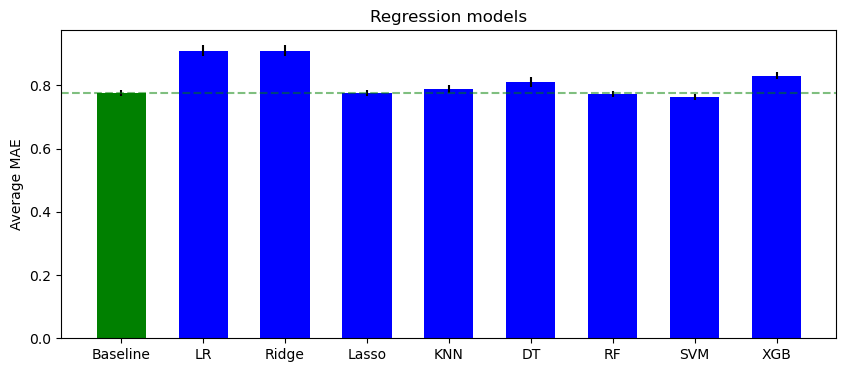

In [34]:
# Retrieve the average MAE and the standard error of the MAE. 
mae = [df_summary_lr['mae_baseline'].mean(), 
       df_summary_lr['mae_model'].mean(), 
       df_summary_ridge['mae_model'].mean(), 
       df_summary_lasso['mae_model'].mean(), 
       df_summary_knn['mae_model'].mean(), 
       df_summary_dt['mae_model'].mean(), 
       df_summary_rf['mae_model'].mean(), 
       df_summary_svm['mae_model'].mean(),
       df_summary_xgb['mae_model'].mean()]
mae_se = [np.std(df_summary_lr['mae_baseline']) / np.sqrt(df_summary_lr['mae_baseline'].shape[0]), 
          np.std(df_summary_lr['mae_model']) / np.sqrt(df_summary_lr['mae_model'].shape[0]), 
          np.std(df_summary_ridge['mae_model']) / np.sqrt(df_summary_ridge['mae_model'].shape[0]), 
          np.std(df_summary_lasso['mae_model']) / np.sqrt(df_summary_lasso['mae_model'].shape[0]), 
          np.std(df_summary_knn['mae_model']) / np.sqrt(df_summary_knn['mae_model'].shape[0]), 
          np.std(df_summary_dt['mae_model']) / np.sqrt(df_summary_dt['mae_model'].shape[0]), 
          np.std(df_summary_rf['mae_model']) / np.sqrt(df_summary_rf['mae_model'].shape[0]), 
          np.std(df_summary_svm['mae_model']) / np.sqrt(df_summary_svm['mae_model'].shape[0]),
          np.std(df_summary_xgb['mae_model']) / np.sqrt(df_summary_xgb['mae_model'].shape[0])]

# Display the average MAE and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 4))
axes.bar(range(9), mae, width = 0.6, color = ['green', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'])
axes.errorbar(range(9), mae, yerr = mae_se, fmt = 'None', color = 'black')
axes.axhline(mae[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(9), labels = ['Baseline', 'LR', 'Ridge', 'Lasso', 'KNN', 'DT', 'RF', 'SVM', 'XGB'])
axes.set_ylabel('Average MAE')
axes.set_title('Regression models');

In [35]:
# Save the features into Pickle files. 
with open(preprocessed_data_path + 'regression/dict_features_regression_basis.p', 'wb') as file:
    pickle.dump(dict_features_basis, file)
with open(preprocessed_data_path + 'regression/dict_features_regression_sequence.p', 'wb') as file:
    pickle.dump(dict_features_sequence, file)
    
# Save the targets into Pickle files. 
with open(preprocessed_data_path + 'regression/dict_targets_regression_basis.p', 'wb') as file:
    pickle.dump(dict_targets_basis, file)
with open(preprocessed_data_path + 'regression/dict_targets_regression_sequence.p', 'wb') as file:
    pickle.dump(dict_targets_sequence, file)

# Save the baselines into Pickle files. 
with open(preprocessed_data_path + 'regression/dict_baseline_regression_basis.p', 'wb') as file:
    pickle.dump(dict_baseline_basis, file)
with open(preprocessed_data_path + 'regression/dict_baseline_regression_sequence.p', 'wb') as file:
    pickle.dump(dict_baseline_sequence, file)

# Save the models into Pickle files. 
with open(results_path + 'regression/dict_models_lr.p', 'wb') as file:
    pickle.dump(dict_models_lr, file)
with open(results_path + 'regression/dict_models_ridge.p', 'wb') as file:
    pickle.dump(dict_models_ridge, file)
with open(results_path + 'regression/dict_models_lasso.p', 'wb') as file:
    pickle.dump(dict_models_lasso, file)
with open(results_path + 'regression/dict_models_knn.p', 'wb') as file:
    pickle.dump(dict_models_knn, file)
with open(results_path + 'regression/dict_models_dt.p', 'wb') as file:
    pickle.dump(dict_models_dt, file)
with open(results_path + 'regression/dict_models_rf.p', 'wb') as file:
    pickle.dump(dict_models_rf, file)
with open(results_path + 'regression/dict_models_svm.p', 'wb') as file:
    pickle.dump(dict_models_svm, file)